<a href="https://colab.research.google.com/github/JuanPabl07DP/AgeOfEmpires/blob/main/AgeOfEmpires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **El arte de la guerra.**
## ***Inspirado en Age of Empires II.***

### Por: Juan Pablo Daza Pereira y Juan Sebastian Camargo Sanchez.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
pip install matplotlib

# **Adaptacion de código junto a la generación del ambiente**

In [3]:
# AJUSTE DE RECURSOS Y VELOCIDADES DE RECOLECCIÓN
#--------------------------------------------------------------------------------------------------------------------------
velocidades = {
    0: 0.5,  # Oro
    1: 1.0,  # Comida
    2: 0.8   # Madera
}

# ALDEANOS POR ERA
aldeanos_por_era = [6, 15, 36, 58]

# TIEMPO PROM. POR ERA
tiempo = [15,22,35,60]

In [4]:
# INDIVIDUAL Y POBLACIÓN Y FITNESS
#--------------------------------------------------------------------------------------------------------------------------
def individual(genes, min_val, max_val):
  return [random.randint(min_val, max_val) for _ in range(genes)] # Creamos un individuo random

def population(size, genes, min_val, max_val):
  return [individual(genes, min_val, max_val) for _ in range(size)] # Creamos una nueva poblacion de individuos

def fitness(individual, fitness_function, era, pBalance):
  return fitness_function(individual, era, pBalance)

In [5]:
# MUTACIÓN Y CRUCE
#--------------------------------------------------------------------------------------------------------------------------
def mutate(individual, points, rate, min_val, max_val):
    nuevo_individual = individual[:]  # Copia el individuo original
    for _ in range(points):
        if random.random() < rate:
            indice = random.randint(0, len(individual) - 1)  # Elige un índice aleatorio
            nuevo_individual[indice] = random.randint(min_val, max_val)
    return nuevo_individual

def crossover(partnerA, partnerB, points, rate):
    if random.random() > rate:
        return partnerA[:], partnerB[:] # Devuelve los padres

    crossoverA, crossoverB = partnerA[:], partnerB[:]
    crossover_points = sorted(random.sample(range(len(partnerA)), points)) # Crossover aleatorios

    for i in range(0, len(crossover_points), 2):
        start = crossover_points[i]
        end = crossover_points[i + 1] if i + 1 < len(crossover_points) else len(partnerA)
        crossoverA[start:end], crossoverB[start:end] = crossoverB[start:end], crossoverA[start:end]

    return crossoverA, crossoverB

In [6]:
# SELECCIÓN
#--------------------------------------------------------------------------------------------------------------------------
def tournament(population, fitness_function, size, era, pBalance,tournament_size=3):
    selected = []  # Lista para almacenar individuos seleccionados

    for _ in range(size):
        # Individuos seleccionados al azar para participar en el torneo
        tournament_participants = random.sample(population, tournament_size)

        # Elige al ganador del torneo (el de mejor fitness)
        tournament_win = max(tournament_participants, key=lambda ind: fitness_function(ind, era,pBalance))
        selected.append(tournament_win)

    return selected

In [7]:
# CÁLCULO DE RECURSOS RECOLECTADOS
#--------------------------------------------------------------------------------------------------------------------------
def calcular_recursos_recolectados(individual):
    oro = individual[0] * velocidades[0]
    comida = individual[1] * velocidades[1]
    madera = individual[2] * velocidades[2]
    return oro, comida, madera

# EVOLUCIÓN A TRAVÉS DE LAS ERAS
#--------------------------------------------------------------------------------------------------------------------------
def evolve_across_eras(size ,genes, selection, mutation_points, mutation_rate, crossover_points, crossover_rate, iterations_por_era, print_interval, pBalance):
    best_individual_por_era = []
    fitness_por_era = []
    recursos_por_era = []

    for era, aldeanos_disponibles in enumerate(aldeanos_por_era):
        print(f"\n--- Era {era + 1} ---")
        min_val = 0
        max_val = aldeanos_disponibles
        print(min_val,max_val)
        pop = population(size, genes, min_val, max_val)
        best_fitness_por_gen = []  # Lista para almacenar el mejor fitness por generación

        for gen in range(iterations_por_era):
            # Selección por torneo, pasando la era actual
            selected = selection(pop, fitness_function, size, era, pBalance)

            best_individual = max(pop, key=lambda ind: fitness_function(ind, era, pBalance))
            best_fitness = fitness_function(best_individual, era, pBalance)

            best_fitness_por_gen.append(best_fitness)

            new_pop = []  # Nueva población
            for i in range(0, pop_size, 2):
                parentA = selected[i]
                parentB = selected[i+1]

                crossoverA, crossoverB = crossover(parentA, parentB, crossover_points, crossover_rate) # Realiza el crossover entre los padres

                crossoverA = mutate(crossoverA, mutation_points, mutation_rate, min_val, max_val)
                crossoverB = mutate(crossoverB, mutation_points, mutation_rate, min_val, max_val)

                new_pop.append(crossoverA)
                new_pop.append(crossoverB)
            if gen % print_interval == 0:
                print(f"Generation {gen}: Best Individual = {best_individual}, Fitness = {best_fitness}")

            new_pop[0] = best_individual  # Conservamos el mejor individuo
            pop = new_pop

        # Guardar el mejor individuo y su fitness
        best_individual_por_era.append(best_individual)
        fitness_por_era.append(best_fitness_por_gen)

        oro, comida, madera = calcular_recursos_recolectados(best_individual)
        recursos_por_era.append((oro, comida, madera))

        print(f"Best individual of Era {era + 1}: {best_individual}, Fitness = {best_fitness}")
        print(f"Resources collected: Oro = {tiempo[era] * oro:.2f}, Comida = {tiempo[era] * comida:.2f}, Madera = {tiempo[era] * madera:.2f}")

    return best_individual_por_era, fitness_por_era, recursos_por_era

# **EJECUCION DEL ALGORITMO**

In [8]:
# FITNESS FUNCTION
#--------------------------------------------------------------------------------------------------------------------------
def fitness_function(individual, era, pBalance = 0.5):
    # individual[0]: número de aldeanos asignados al oro
    # individual[1]: número de aldeanos asignados a la comida
    # individual[2]: número de aldeanos asignados a la madera
    total_aldeanos = sum(individual)

    # Verificar que no se exceda el número de aldeanos disponibles en la era actual
    if total_aldeanos > aldeanos_por_era[era]:
        # Penalizar si se usan más aldeanos de los disponibles
        return -1 * (total_aldeanos - aldeanos_por_era[era])  # Penalización progresiva

    # Cantidad de recursos recolectados por cada recurso
    oro_recolectado = individual[0] * velocidades[0] * tiempo[era]  # Oro recolectado
    comida_recolectada = individual[1] * velocidades[1] * tiempo[era]  # Comida recolectada
    madera_recolectada = individual[2] * velocidades[2] * tiempo[era]  # Madera recolectada

    # Balancear la diferencia entre los recursos recolectados
    max_diferencia = max(abs(oro_recolectado - comida_recolectada),
                         abs(comida_recolectada - madera_recolectada),
                         abs(madera_recolectada - oro_recolectado))

    # Queremos maximizar la suma total de recursos y minimizar las diferencias entre ellos
    total_recursos = oro_recolectado + comida_recolectada + madera_recolectada

    # Ponderar la función de fitness: maximizar recursos y minimizar diferencias
    fitness = total_recursos - (pBalance * max_diferencia)  # Ajusta el peso según lo que priorices

    return fitness



--- Era 1 ---
0 6
Generation 0: Best Individual = [1, 3, 2], Fitness = 57.75
Generation 10: Best Individual = [1, 2, 3], Fitness = 59.25
Generation 20: Best Individual = [1, 2, 3], Fitness = 59.25
Best individual of Era 1: [2, 2, 2], Fitness = 61.5
Resources collected: Oro = 15.00, Comida = 30.00, Madera = 24.00

--- Era 2 ---
0 15
Generation 0: Best Individual = [8, 3, 4], Fitness = 213.4
Generation 10: Best Individual = [8, 3, 4], Fitness = 213.4
Generation 20: Best Individual = [8, 3, 4], Fitness = 213.4
Best individual of Era 2: [7, 3, 5], Fitness = 220.0
Resources collected: Oro = 77.00, Comida = 66.00, Madera = 88.00

--- Era 3 ---
0 36
Generation 0: Best Individual = [15, 12, 5], Fitness = 682.5
Generation 10: Best Individual = [9, 12, 14], Fitness = 838.25
Generation 20: Best Individual = [9, 12, 15], Fitness = 866.25
Best individual of Era 3: [9, 12, 15], Fitness = 866.25
Resources collected: Oro = 157.50, Comida = 420.00, Madera = 420.00

--- Era 4 ---
0 58
Generation 0: Bes

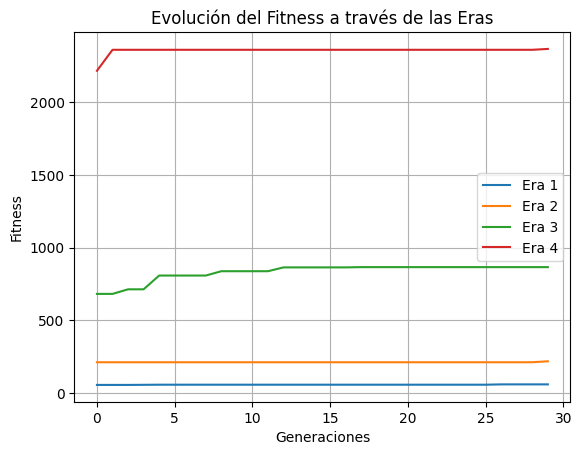


--- Evolution completed ---
Era 1: Oro = 15.00, Comida = 30.00, Madera = 24.00
Era 2: Oro = 77.00, Comida = 66.00, Madera = 88.00
Era 3: Oro = 157.50, Comida = 420.00, Madera = 420.00
Era 4: Oro = 600.00, Comida = 960.00, Madera = 1008.00


In [9]:
# CÓDIGO PRINCIPAL
#--------------------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    pop_size = 50         # Tamaño de la población
    mutation_points = 1    # Puntos de mutación
    mutation_rate = 0.5    # Probabilidad de mutación
    crossover_points = 1   # Puntos de cruce
    crossover_rate = 0.5   # Probabilidad de cruce
    iterations_por_era = 30  # Generaciones por era
    print_interval = 10    # Cada cuántas generaciones imprimir el progreso
    pBalance = 0.5 # Porcentaje de balance entre los recursos
    selection = tournament # Seleccion por torneo -> SOLO ESTA IMPLEMENTADO
    genes = 3

    # Evolve through all eras
    best_individuals, fitness_por_era, recursos_por_era = evolve_across_eras(
        pop_size ,genes, selection, mutation_points, mutation_rate, crossover_points, crossover_rate,
        iterations_por_era, print_interval, pBalance
    )

    # Graficar los resultados
    for era, fitness_per_gen in enumerate(fitness_por_era):
        plt.plot(fitness_per_gen, label=f'Era {era + 1}')

    plt.xlabel('Generaciones')
    plt.ylabel('Fitness')
    plt.title('Evolución del Fitness a través de las Eras')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar los recursos recolectados en cada era
    print("\n--- Evolution completed ---")
    for era, (oro, comida, madera) in enumerate(recursos_por_era):
        print(f"Era {era + 1}: Oro = {tiempo[era] * oro:.2f}, Comida = {tiempo[era] * comida:.2f}, Madera = {tiempo[era] * madera:.2f}")


--- Era 1 ---
0 6
Generation 0: Best Individual = [3, 1, 2], Fitness = 52.5
Generation 10: Best Individual = [3, 1, 2], Fitness = 52.5
Generation 20: Best Individual = [3, 1, 2], Fitness = 52.5
Best individual of Era 1: [3, 1, 2], Fitness = 52.5
Resources collected: Oro = 22.50, Comida = 15.00, Madera = 24.00

--- Era 2 ---
0 15
Generation 0: Best Individual = [4, 5, 5], Fitness = 176.0
Generation 10: Best Individual = [7, 3, 5], Fitness = 209.0
Generation 20: Best Individual = [7, 3, 5], Fitness = 209.0
Best individual of Era 2: [7, 3, 5], Fitness = 209.0
Resources collected: Oro = 77.00, Comida = 66.00, Madera = 88.00

--- Era 3 ---
0 36
Generation 0: Best Individual = [15, 14, 6], Fitness = 598.5
Generation 10: Best Individual = [16, 8, 10], Fitness = 840.0
Generation 20: Best Individual = [16, 8, 10], Fitness = 840.0
Best individual of Era 3: [17, 9, 10], Fitness = 857.5
Resources collected: Oro = 297.50, Comida = 315.00, Madera = 280.00

--- Era 4 ---
0 58
Generation 0: Best Indi

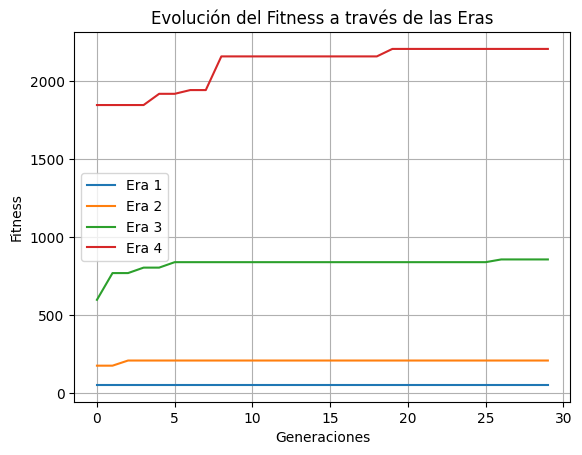


--- Evolution completed ---
Era 1: Oro = 22.50, Comida = 15.00, Madera = 24.00
Era 2: Oro = 77.00, Comida = 66.00, Madera = 88.00
Era 3: Oro = 297.50, Comida = 315.00, Madera = 280.00
Era 4: Oro = 600.00, Comida = 1020.00, Madera = 1008.00


In [10]:
# CÓDIGO PRINCIPAL
#--------------------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    pop_size = 50         # Tamaño de la población
    mutation_points = 1    # Puntos de mutación
    mutation_rate = 0.5    # Probabilidad de mutación
    crossover_points = 1   # Puntos de cruce
    crossover_rate = 0.5   # Probabilidad de cruce
    iterations_por_era = 30  # Generaciones por era
    print_interval = 10    # Cada cuántas generaciones imprimir el progreso
    pBalance = 1 # Porcentaje de balance entre los recursos
    selection = tournament # Seleccion por torneo -> SOLO ESTA IMPLEMENTADO
    genes = 3

    # Evolve through all eras
    best_individuals, fitness_por_era, recursos_por_era = evolve_across_eras(
        pop_size ,genes, selection, mutation_points, mutation_rate, crossover_points, crossover_rate,
        iterations_por_era, print_interval, pBalance
    )

    # Graficar los resultados
    for era, fitness_per_gen in enumerate(fitness_por_era):
        plt.plot(fitness_per_gen, label=f'Era {era + 1}')

    plt.xlabel('Generaciones')
    plt.ylabel('Fitness')
    plt.title('Evolución del Fitness a través de las Eras')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar los recursos recolectados en cada era
    print("\n--- Evolution completed ---")
    for era, (oro, comida, madera) in enumerate(recursos_por_era):
        print(f"Era {era + 1}: Oro = {tiempo[era] * oro:.2f}, Comida = {tiempo[era] * comida:.2f}, Madera = {tiempo[era] * madera:.2f}")


--- Era 1 ---
0 6
Generation 0: Best Individual = [2, 2, 2], Fitness = 69.0
Generation 10: Best Individual = [0, 6, 0], Fitness = 90.0
Generation 20: Best Individual = [0, 6, 0], Fitness = 90.0
Best individual of Era 1: [0, 6, 0], Fitness = 90.0
Resources collected: Oro = 0.00, Comida = 90.00, Madera = 0.00

--- Era 2 ---
0 15
Generation 0: Best Individual = [3, 11, 1], Fitness = 292.6
Generation 10: Best Individual = [3, 11, 1], Fitness = 292.6
Generation 20: Best Individual = [0, 13, 1], Fitness = 303.6
Best individual of Era 2: [0, 14, 1], Fitness = 325.6
Resources collected: Oro = 0.00, Comida = 308.00, Madera = 17.60

--- Era 3 ---
0 36
Generation 0: Best Individual = [4, 7, 25], Fitness = 1015.0
Generation 10: Best Individual = [4, 27, 5], Fitness = 1155.0
Generation 20: Best Individual = [4, 27, 5], Fitness = 1155.0
Best individual of Era 3: [4, 27, 5], Fitness = 1155.0
Resources collected: Oro = 70.00, Comida = 945.00, Madera = 140.00

--- Era 4 ---
0 58
Generation 0: Best Ind

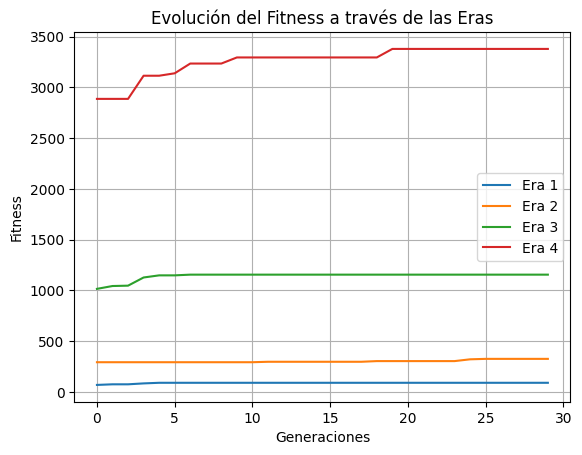


--- Evolution completed ---
Era 1: Oro = 0.00, Comida = 90.00, Madera = 0.00
Era 2: Oro = 0.00, Comida = 308.00, Madera = 17.60
Era 3: Oro = 70.00, Comida = 945.00, Madera = 140.00
Era 4: Oro = 30.00, Comida = 3060.00, Madera = 288.00


In [11]:
# CÓDIGO PRINCIPAL
#--------------------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    pop_size = 50         # Tamaño de la población
    mutation_points = 1    # Puntos de mutación
    mutation_rate = 0.5    # Probabilidad de mutación
    crossover_points = 1   # Puntos de cruce
    crossover_rate = 0.5   # Probabilidad de cruce
    iterations_por_era = 30  # Generaciones por era
    print_interval = 10    # Cada cuántas generaciones imprimir el progreso
    pBalance = 0 # Porcentaje de balance entre los recursos
    selection = tournament # Seleccion por torneo -> SOLO ESTA IMPLEMENTADO
    genes = 3

    # Evolve through all eras
    best_individuals, fitness_por_era, recursos_por_era = evolve_across_eras(
        pop_size ,genes, selection, mutation_points, mutation_rate, crossover_points, crossover_rate,
        iterations_por_era, print_interval, pBalance
    )

    # Graficar los resultados
    for era, fitness_per_gen in enumerate(fitness_por_era):
        plt.plot(fitness_per_gen, label=f'Era {era + 1}')

    plt.xlabel('Generaciones')
    plt.ylabel('Fitness')
    plt.title('Evolución del Fitness a través de las Eras')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar los recursos recolectados en cada era
    print("\n--- Evolution completed ---")
    for era, (oro, comida, madera) in enumerate(recursos_por_era):
        print(f"Era {era + 1}: Oro = {tiempo[era] * oro:.2f}, Comida = {tiempo[era] * comida:.2f}, Madera = {tiempo[era] * madera:.2f}")

# **Priorizar el recurso indicado**

In [12]:
# RECURSOS, VELOCIDADES DE RECOLECCIÓN Y BONOS
#--------------------------------------------------------------------------------------------------------------------------
velocidades = {
    0: 0.5,  # Oro
    1: 1.0,  # Comida
    2: 0.8   # Madera
}

# La Suma de los bonos debe ser de 10 para un funcionamiento correcto
# Oro, Comida, Madera. Respectivamente.
bonos = [6, 2, 2]  # 4 para oro, 4 para comida, y 2 para madera

#TIEMPO PROM. POR ERA
tiempo = [15,22,35,60]

# ALDEANOS POR ERA
aldeanos_por_era = [6, 15, 36, 58]

In [13]:
# FITNESS FUNCTION
#--------------------------------------------------------------------------------------------------------------------------
def fitness_function(individual, era, pBalance = 0.5):
    # individual[0]: número de aldeanos asignados al oro
    # individual[1]: número de aldeanos asignados a la comida
    # individual[2]: número de aldeanos asignados a la madera

    total_aldeanos = sum(individual)

    # Verificar que no se exceda el número de aldeanos disponibles en la era actual
    if total_aldeanos > aldeanos_por_era[era]:
        # Penalizar si se usan más aldeanos de los disponibles
        return -1 * (total_aldeanos - aldeanos_por_era[era])  # Penalización progresiva

    # Normalización del bono: ajustamos los bonos para que sumen 1
    total_bonos = sum(bonos)
    bonos_normalizados = [b / total_bonos for b in bonos]  # Ajusta para que la suma de los bonos sea 1


    # Cantidad de recursos recolectados por cada recurso en función del tiempo y aplicando el bono ponderado
    oro_recolectado = individual[0] * velocidades[0] * tiempo[era] * bonos_normalizados[0]
    comida_recolectada = individual[1] * velocidades[1] * tiempo[era] * bonos_normalizados[1]
    madera_recolectada = individual[2] * velocidades[2] * tiempo[era] * bonos_normalizados[2]

    # Balancear la diferencia entre los recursos recolectados
    max_diferencia = max(abs(oro_recolectado - comida_recolectada),
                         abs(comida_recolectada - madera_recolectada),
                         abs(madera_recolectada - oro_recolectado))

    # Queremos maximizar la suma total de recursos y minimizar las diferencias entre ellos
    total_recursos_prioridad = oro_recolectado + comida_recolectada + madera_recolectada

    # Ponderar la función de fitness: maximizar recursos y minimizar diferencias
    fitness = total_recursos_prioridad - (pBalance * max_diferencia)  # Ajusta el peso según lo que priorices

    return fitness


--- Era 1 ---
0 6
Generation 0: Best Individual = [6, 0, 0], Fitness = 18.9
Generation 10: Best Individual = [6, 0, 0], Fitness = 18.9
Generation 20: Best Individual = [6, 0, 0], Fitness = 18.9
Best individual of Era 1: [6, 0, 0], Fitness = 18.9
Resources collected: Oro = 45.00, Comida = 0.00, Madera = 0.00

--- Era 2 ---
0 15
Generation 0: Best Individual = [8, 6, 1], Fitness = 67.936
Generation 10: Best Individual = [11, 2, 2], Fitness = 68.772
Generation 20: Best Individual = [11, 2, 2], Fitness = 68.772
Best individual of Era 2: [11, 2, 2], Fitness = 68.772
Resources collected: Oro = 121.00, Comida = 44.00, Madera = 35.20

--- Era 3 ---
0 36
Generation 0: Best Individual = [19, 14, 2], Fitness = 252.20999999999998
Generation 10: Best Individual = [22, 11, 3], Fitness = 260.54
Generation 20: Best Individual = [29, 5, 2], Fitness = 262.71
Best individual of Era 3: [29, 5, 2], Fitness = 262.71
Resources collected: Oro = 507.50, Comida = 175.00, Madera = 56.00

--- Era 4 ---
0 58
Gene

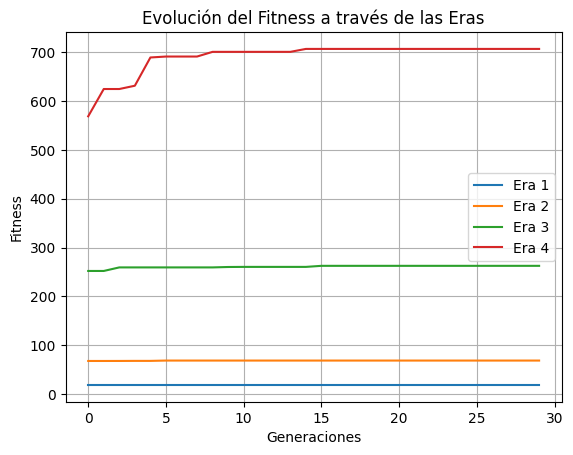


--- Evolution completed ---
Era 1: Oro = 45.00, Comida = 0.00, Madera = 0.00
Era 2: Oro = 121.00, Comida = 44.00, Madera = 35.20
Era 3: Oro = 507.50, Comida = 175.00, Madera = 56.00
Era 4: Oro = 480.00, Comida = 1020.00, Madera = 1200.00


In [14]:
# CÓDIGO PRINCIPAL
#--------------------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    pop_size = 50         # Tamaño de la población
    mutation_points = 1    # Puntos de mutación
    mutation_rate = 0.5    # Probabilidad de mutación
    crossover_points = 1   # Puntos de cruce
    crossover_rate = 0.5   # Probabilidad de cruce
    iterations_por_era = 30  # Generaciones por era
    print_interval = 10    # Cada cuántas generaciones imprimir el progreso
    pBalance = 0.3 # Porcentaje de balance entre los recursos
    selection = tournament # Seleccion por torneo -> SOLO ESTA IMPLEMENTADO
    genes = 3

    # Evolve through all eras
    best_individuals, fitness_por_era, recursos_por_era = evolve_across_eras(
        pop_size ,genes, selection, mutation_points, mutation_rate, crossover_points, crossover_rate,
        iterations_por_era, print_interval, pBalance
    )

    # Graficar los resultados
    for era, fitness_per_gen in enumerate(fitness_por_era):
        plt.plot(fitness_per_gen, label=f'Era {era + 1}')

    plt.xlabel('Generaciones')
    plt.ylabel('Fitness')
    plt.title('Evolución del Fitness a través de las Eras')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar los recursos recolectados en cada era
    print("\n--- Evolution completed ---")
    for era, (oro, comida, madera) in enumerate(recursos_por_era):
        print(f"Era {era + 1}: Oro = {tiempo[era] * oro:.2f}, Comida = {tiempo[era] * comida:.2f}, Madera = {tiempo[era] * madera:.2f}")